# The spelled-out intro to neural networks and backpropagation: building micrograd
## Lecture notes

 Notes from following along [this lecture from Karpathy on YT](https://www.youtube.com/watch?v=VMj-3S1tku0).
 
 Link to micrograd library also [here](https://github.com/karpathy/micrograd).
 

### Intuition of a derivative

First setting up what a derivative does

In [82]:
import math
import random
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [83]:
def f(x):
    return 3*x**2 - 4*x + 5

In [84]:
f(3)

20

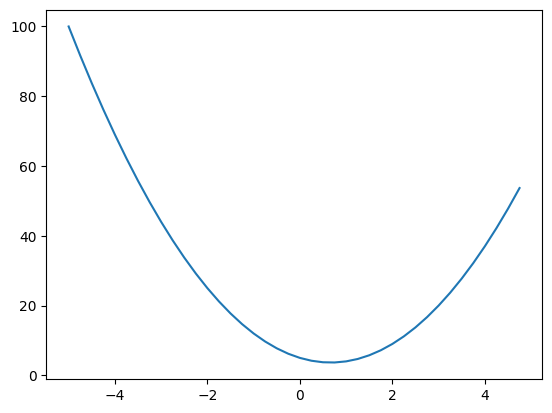

In [85]:
xs = np.arange(-5, 5, 0.25)
ys = f(xs)
plt.plot(xs, ys)

In [86]:
h = 0.00000001
x = 2/3
(f(x+h) - f(x))/h # numerical approximation of the derivative


0.0

In [87]:
# getting more complex
a = 2.0
b = -3.0
c = 10.0
d = a*b + c
print(d)

4.0


In [88]:
h = 0.0001

# inputs
a = 2.0
b = -3.0
c = 10.0

d1 = a*b + c
b += h
d2 = a*b + c

print('d1:', d1)
print('d2:', d2)
print('slope', (d2-d1)/h)
# a's derivative is ~-3 which makes sense given that is the value of b
# b's derivative is ~2 which makes sense given that is the value of a
# c's derivative is ~1 which makes sense given that it is simply an addition with no multipliers

d1: 4.0
d2: 4.0002
slope 2.0000000000042206


### Starting to build out micrograd

In [89]:
class Value:
    def __init__(self, data, _children=(), _op='', label=''):
        self.data = data
        self.grad = 0.0
        self._prev = set(_children)
        self._op = _op
        self.label = label
        
    def __repr__(self):
        return f"Value(data=({self.data})"

    def __add__(self, other):
        out = Value(self.data + other.data, (self, other), '+')
        return out

    def __mul__(self, other):
        out = Value(self.data * other.data, (self, other), '*')
        return out

a = Value(2.0, label='a')
b = Value(-3.0, label='b')
c = Value(10.0, label='c')
e = a*b; e.label = 'e'
d = e + c
d.label = 'd'
f = Value(-2.0, label='f')
L = d * f
L.label = 'L'
L

Value(data=(-8.0)

In [90]:
d._prev

{Value(data=(-6.0), Value(data=(10.0)}

In [91]:
d._op

'+'

### Visualizing the graph

In [92]:
from graphviz import Digraph

def trace(root):
  # builds a set of all nodes and edges in a graph
  nodes, edges = set(), set()
  def build(v):
    if v not in nodes:
      nodes.add(v)
      for child in v._prev:
        edges.add((child, v))
        build(child)
  build(root)
  return nodes, edges

def draw_dot(root):
  dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = left to right
  
  nodes, edges = trace(root)
  for n in nodes:
    uid = str(id(n))
    # for any value in the graph, create a rectangular ('record') node for it
    dot.node(name = uid, label = "{ %s | data %.4f | grad %.4f}" % (n.label, n.data, n.grad), shape='record')
    if n._op:
      # if this value is a result of some operation, create an op node for it
      dot.node(name = uid + n._op, label = n._op)
      # and connect this node to it
      dot.edge(uid + n._op, uid)

  for n1, n2 in edges:
    # connect n1 to the op node of n2
    dot.edge(str(id(n1)), str(id(n2)) + n2._op)

  return dot

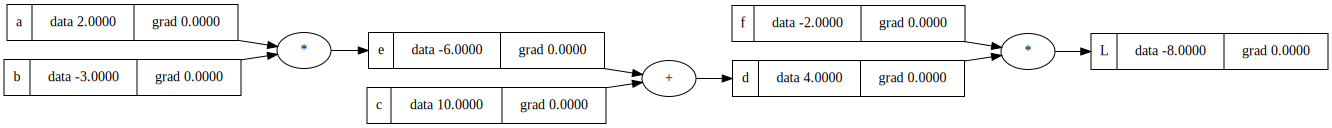

In [93]:
draw_dot(L)

### Introducing the chain rule for calculating the gradients of indirect nodes

How do we calculate dL / dc (or de since they are the same depth away) ?

First start with dd / dc:
- d = c + e
- remember the formula: (f(x+h) - f(x)) / h
- for us it is ((c+h + e) - (c + e)) / h
- simplifies to (h + c + e - c - e) / h
- h / h = 1
- same for dd / de since it is addition and it is symmetrical

Since we know the dL / dd already (it is 4), how do we put them together to get dL / dd? **Answer: chain rule** 

I like this explanation from [the intuitive explanation on Wikipedia](https://en.wikipedia.org/wiki/Chain_rule#Intuitive_explanation): *"If a car travels twice as fast as a bicycle and the bicycle is four times as fast as a walking man, then the car travels 2 × 4 = 8 times as fast as the man."*

Bringing back to our example model:
- We want: dL / dc
- We have: dL / dd (-2) and dd / dc (1)
- So we need to apply the chain rule: dL / dc = (dL / dd) * (dd / dc)
- dL / dc = -2 * 1 = -2
- This will be the same for e as well and will be stored in e.grad and c.grad


In [94]:
# showing that our intuitive explanation above matches the truth for singular parent
# adding what is calculated on paper
L.grad = 1.0
d.grad = -2.0
f.grad = 4.0

def for_c_or_e():
    h = 0.0001
    
    a = Value(2.0, label='a')
    b = Value(-3.0, label='b')
    c = Value(10.0, label='c')
    e = a*b; e.label = 'e'
    d = e + c
    d.label = 'd'
    f = Value(-2.0, label='f')
    L = d * f
    L.label = 'L'
    L1 = L.data

    a = Value(2.0, label='a')
    b = Value(-3.0, label='b')
    c = Value(10.0 + h, label='c')
    e = a*b; e.label = 'e'
    d = e + c
    d.label = 'd'
    f = Value(-2.0, label='f')
    L = d * f
    L.label = 'L'
    L2 = L.data

    print((L2 - L1)/h)

for_c_or_e()


-1.9999999999953388


We can apply the same logic of the chain rule to a and b as well. You only need to care about the gradient of its child node since that will contain all the information gathered so far:

dL / da = (dL / dc) * (dc / da)

Since we know that  dL / dc is -2 and that a & b are used in a multiplication operation, we know that dc / da (or db) will just be the number they are being multiplied with.
- for a, that is b = -3
- for b, that is a = 2

Then their derivative w.r.t L will be:
- dL / da = -2 (from dL / dc) * -3 (from dc / da) = 6
- dL / db = -2 (from dL / dc) * 2 (from dc / db) = -4

In [95]:
# showing that our intuitive explanation above matches the truth for the initial nodes
# adding what is calculated in a since-deleted cell
c.grad = -2.0
e.grad = -2.0

def for_a_or_b():
    h = 0.0001
    
    a = Value(2.0, label='a')
    b = Value(-3.0, label='b')
    c = Value(10.0, label='c')
    e = a*b; e.label = 'e'
    d = e + c
    d.label = 'd'
    f = Value(-2.0, label='f')
    L = d * f
    L.label = 'L'
    L1 = L.data

    a = Value(2.0 , label='a')
    b = Value(-3.0 + h, label='b')
    c = Value(10.0, label='c')
    e = a*b; e.label = 'e'
    d = e + c
    d.label = 'd'
    f = Value(-2.0, label='f')
    L = d * f
    L.label = 'L'
    L2 = L.data

    print((L2 - L1)/h)

for_a_or_b()


-4.000000000008441


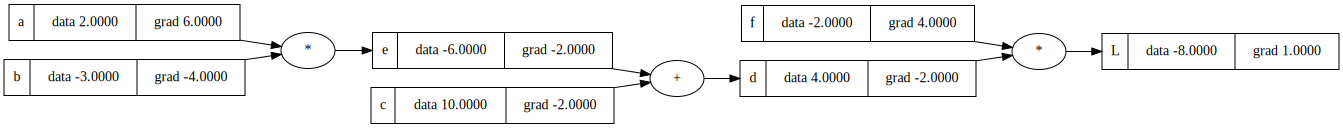

In [96]:
# completed graph
a.grad = 6.0
b.grad = -4.0
draw_dot(L)

### How to use what we learned for a forward pass

We now increment all the "leaf nodes" as Karpathy calls them (which are the ones that do not have any arrows pointing at them) by the gradient amount.


In [97]:
a.data += 0.01 * a.grad
b.data += 0.01 * b.grad
c.data += 0.01 * c.grad
f.data += 0.01 * f.grad

e = a * b
d = e + c
L = d * f

print(L.data)

-7.286496


### Adding in activation function and backprop

Now that we have the idea for a forward pass and backprop done, we need to model the behavior of a simplified neural net.

The final step we need is **an activation function** for the neuron, which is what it will do with all the weights & inputs it is getting (plus an unknown bias term). 

A good choice would be tanh since it squashes to 1 or -1 to signal activation. Here is a chart that shows what that looks like.

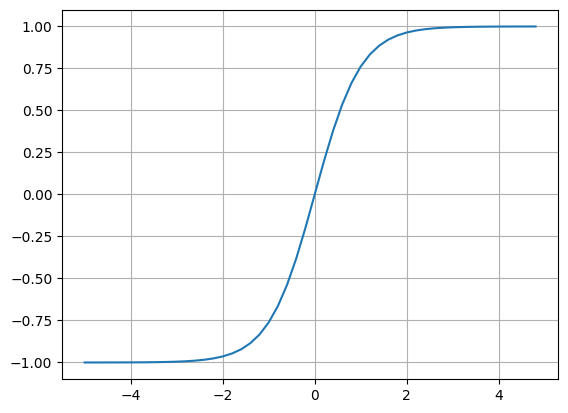

In [98]:
plt.plot(np.arange(-5,5,0.2), np.tanh(np.arange(-5,5,0.2))); plt.grid();

In [99]:
# updating the class definition with tanh
# in the video he does it in place with the first cell but i think this is easier to follow along
class Value:
    def __init__(self, data, _children=(), _op='', label=''):
        self.data = data
        self.grad = 0.0
        self._backward = lambda: None
        self._prev = set(_children)
        self._op = _op
        self.label = label
        
    def __repr__(self):
        return f"Value(data=({self.data})"

    def __add__(self, other):
        out = Value(self.data + other.data, (self, other), '+')

        def _backward():
          self.grad = 1.0 * out.grad
          other.grad = 1.0 * out.grad
        out._backward = _backward
        return out

    def __mul__(self, other):
        out = Value(self.data * other.data, (self, other), '*')

        def _backward():
          self.grad = other.data * out.grad
          other.grad = self.data * out.grad
        out._backward = _backward
        return out

    def tanh(self):
        x = self.data
        t = (math.exp(2*x) - 1)/(math.exp(2*x) + 1)
        out = Value(t, (self, ), 'tanh')

        def _backward():
          self.grad = (1 - t**2) * out.grad
        out._backward = _backward
        return out

    def backward(self):
        topo = []
        visited = set()
        def build_topo(v):
          if v not in visited:
            visited.add(v)
            for child in v._prev:
              build_topo(child)
            topo.append(v)
        build_topo(self)
        
        self.grad = 1.0
        for node in reversed(topo):
          node._backward()

In [100]:
# inputs x1,x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights w1,w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias of the neuron
b = Value(6.8813735870195432, label='b')
# x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'
o = n.tanh(); o.label = 'o'

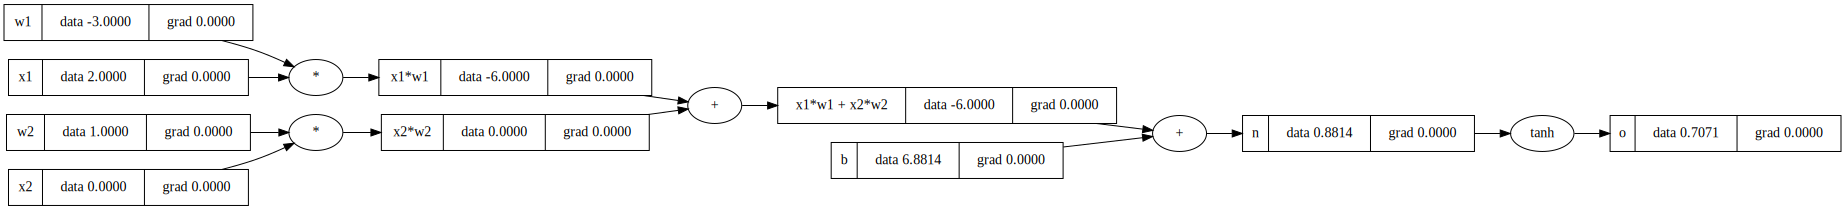

In [101]:
draw_dot(o)

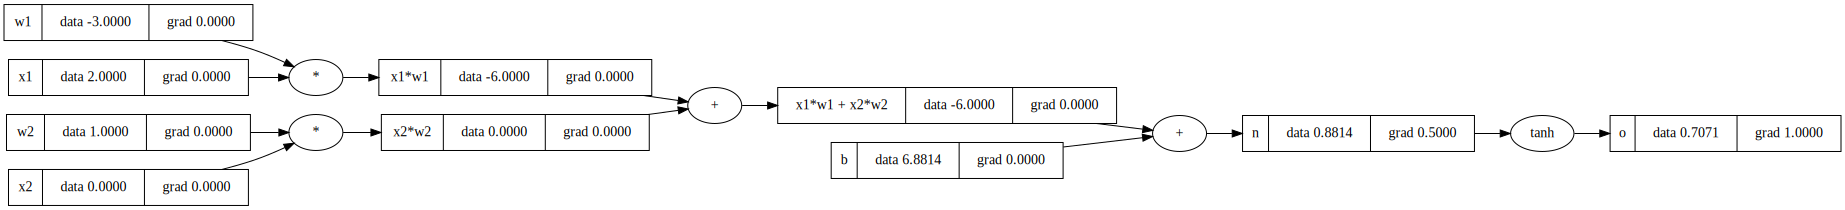

In [102]:
o.grad = 1.0
o._backward()
draw_dot(o)

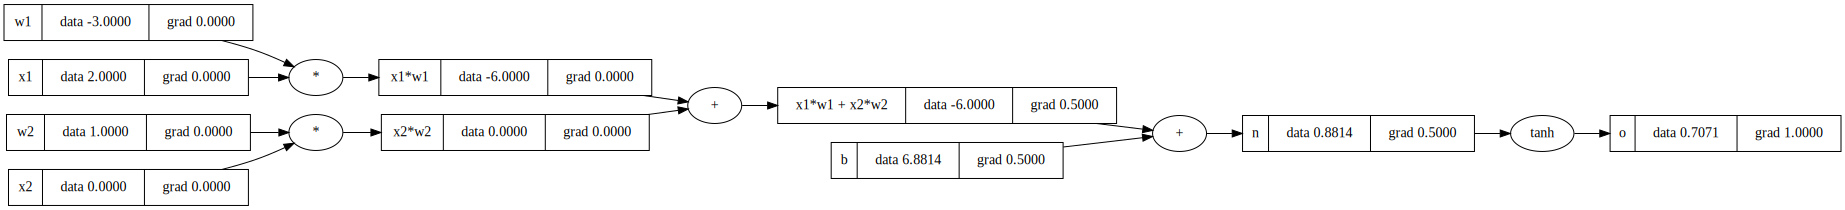

In [103]:
n._backward()
draw_dot(o)

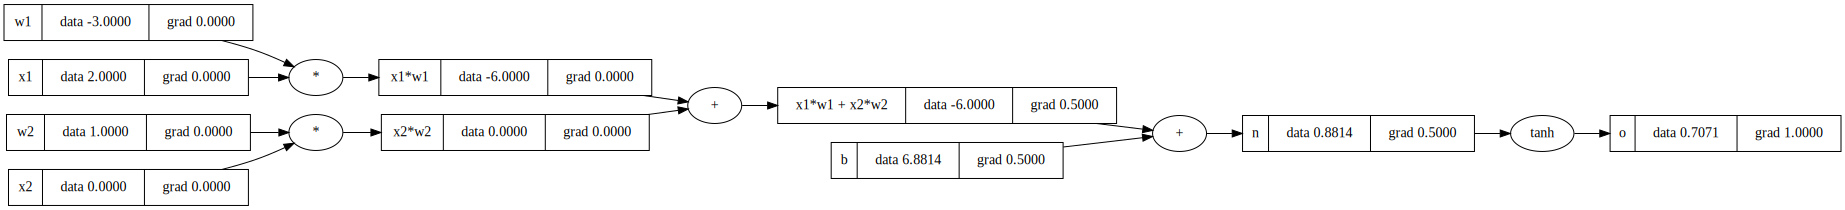

In [104]:
b._backward()
draw_dot(o)

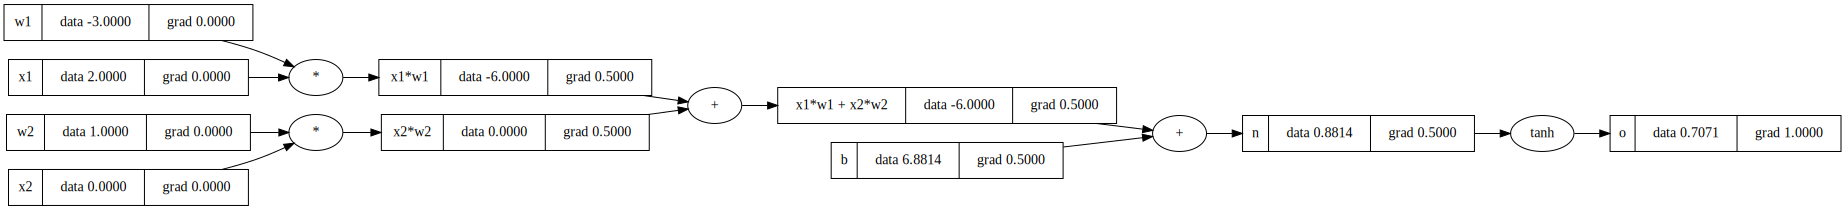

In [105]:
x1w1x2w2._backward()
draw_dot(o)

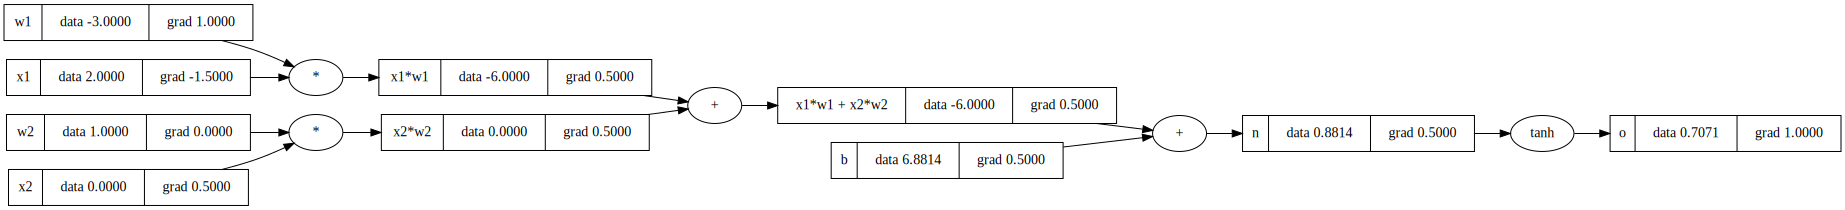

In [106]:
x1w1._backward()
x2w2._backward()
draw_dot(o)

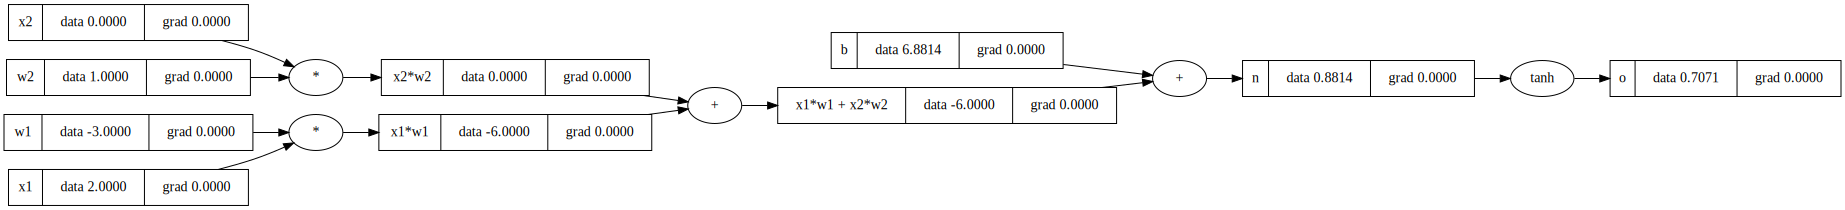

In [107]:
# Or we can automate this by doing a reverse topological sort and calling _backward on it

# First we reset the values
# inputs x1,x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights w1,w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias of the neuron
b = Value(6.8813735870195432, label='b')
# x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'
o = n.tanh(); o.label = 'o'
draw_dot(o)

In [108]:
# then we add the looping logic

o.grad = 1.0

topo = []
visited = set()
def build_topo(v):
    if v not in visited:
        visited.add(v)
        for child in v._prev:
            build_topo(child)
        topo.append(v)
build_topo(o)

for node in reversed(topo):
    node._backward()

# we added this to the bottom of the Value class now as the backward function

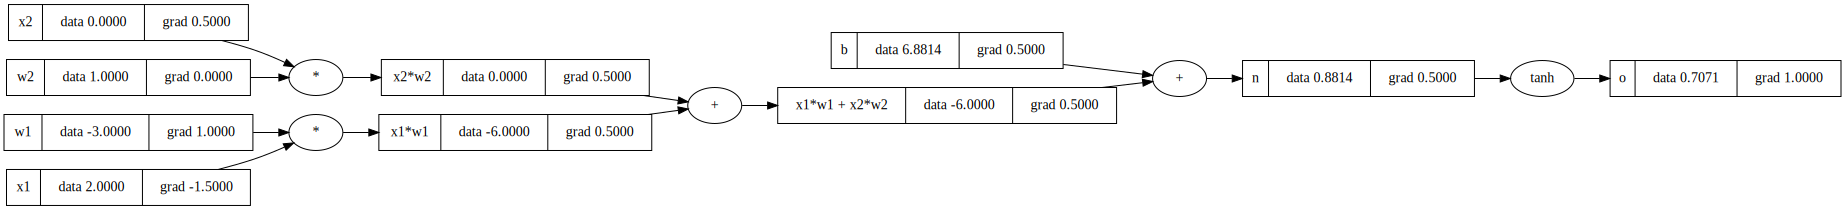

In [109]:
draw_dot(o)

### Bugs in the current version: the multiple use case

Current version of the `Value` class does not support the cases where the same node is used across multiple operations or multiple times.

Here are two examples:

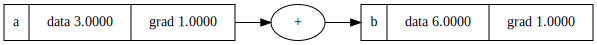

In [110]:
# Using a twice -> the grad should be 2 since it is 1 + 1 but it gets overwritten instead
a = Value(3.0, label='a')
b = a + a   ; b.label = 'b'
b.backward()
draw_dot(b)

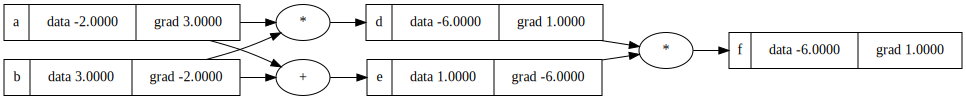

In [111]:
# Same node servicing two separate operations: lead to the same overwriting issue
a = Value(-2.0, label='a')
b = Value(3.0, label='b')
d = a * b    ; d.label = 'd'
e = a + b    ; e.label = 'e'
f = d * e    ; f.label = 'f'

f.backward()

draw_dot(f)

### Final version of the Value class from the lecture notes

This adds:
* the bug fix for the above case (need to use `+=` instead of `=` to accumulate the gradient
* support for the usage of scalars with the addition of `out = Value(self.data + other.data, (self, other), '+')` and reverse operations like `__rmul__`
* support for the power operation with `__pow__` (and division with `/` is just a special case of this)
* support for subtraction using `-` by adding negation under `__neg__`

In [112]:
class Value:
  
  def __init__(self, data, _children=(), _op='', label=''):
    self.data = data
    self.grad = 0.0
    self._backward = lambda: None
    self._prev = set(_children)
    self._op = _op
    self.label = label

  def __repr__(self):
    return f"Value(data={self.data})"
  
  def __add__(self, other):
    other = other if isinstance(other, Value) else Value(other)
    out = Value(self.data + other.data, (self, other), '+')
    
    def _backward():
      self.grad += 1.0 * out.grad
      other.grad += 1.0 * out.grad
    out._backward = _backward
    
    return out

  def __mul__(self, other):
    other = other if isinstance(other, Value) else Value(other)
    out = Value(self.data * other.data, (self, other), '*')
    
    def _backward():
      self.grad += other.data * out.grad
      other.grad += self.data * out.grad
    out._backward = _backward
      
    return out
  
  def __pow__(self, other):
    assert isinstance(other, (int, float)), "only supporting int/float powers for now"
    out = Value(self.data**other, (self,), f'**{other}')

    def _backward():
        self.grad += other * (self.data ** (other - 1)) * out.grad
    out._backward = _backward

    return out
  
  def __rmul__(self, other): # other * self
    return self * other

  def __truediv__(self, other): # self / other
    return self * other**-1

  def __neg__(self): # -self
    return self * -1

  def __sub__(self, other): # self - other
    return self + (-other)

  def __radd__(self, other): # other + self
    return self + other

  def tanh(self):
    x = self.data
    t = (math.exp(2*x) - 1)/(math.exp(2*x) + 1)
    out = Value(t, (self, ), 'tanh')
    
    def _backward():
      self.grad += (1 - t**2) * out.grad
    out._backward = _backward
    
    return out
  
  def exp(self):
    x = self.data
    out = Value(math.exp(x), (self, ), 'exp')
    
    def _backward():
      self.grad += out.data * out.grad # NOTE: in the video I incorrectly used = instead of +=. Fixed here.
    out._backward = _backward
    
    return out
  
  
  def backward(self):
    
    topo = []
    visited = set()
    def build_topo(v):
      if v not in visited:
        visited.add(v)
        for child in v._prev:
          build_topo(child)
        topo.append(v)
    build_topo(self)
    
    self.grad = 1.0
    for node in reversed(topo):
      node._backward()



### Redoing the previous example with exponentiation instead of tanh

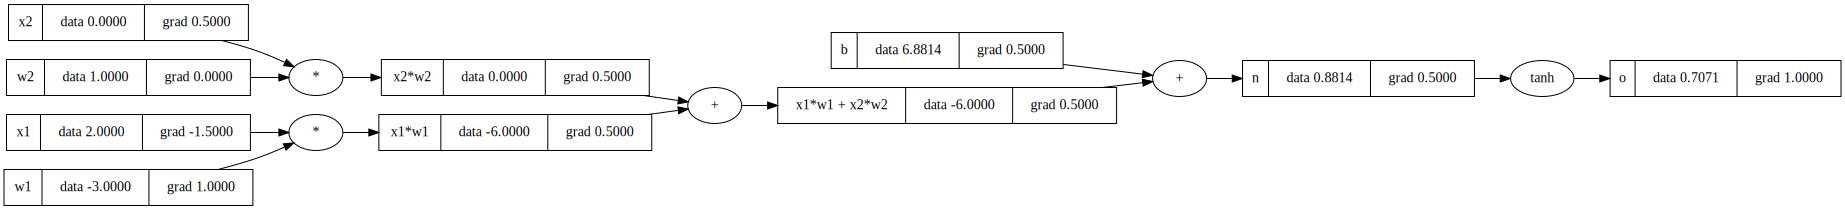

In [113]:
# OLD VERSION WITH TANH
# inputs x1,x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights w1,w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias of the neuron
b = Value(6.8813735870195432, label='b')
# x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'
o = n.tanh(); o.label = 'o'
o.backward()
draw_dot(o)

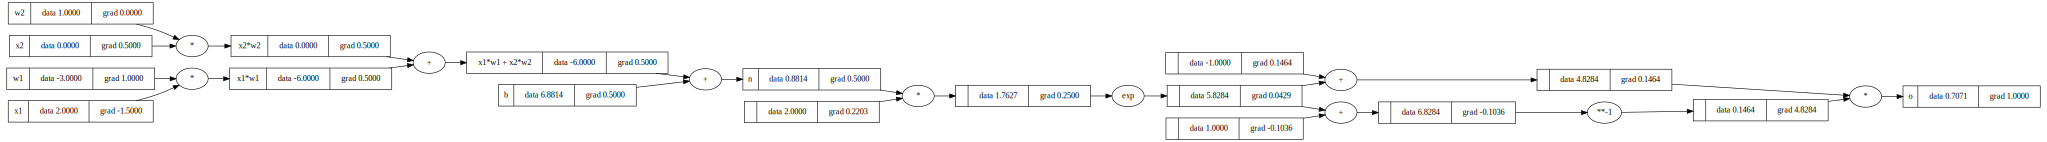

In [114]:
# NEW VERSION WITH EXP
# inputs x1,x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights w1,w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias of the neuron
b = Value(6.8813735870195432, label='b')
# x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'
# ----
e = (2*n).exp()
o = (e - 1) / (e + 1)
# ----
o.label = 'o'
o.backward()
draw_dot(o)

### Torch version

In [115]:
import torch

In [116]:
# to show the gradients of the inputs and the final forward pass output are identical
x1 = torch.Tensor([2.0]).double()                ; x1.requires_grad = True
x2 = torch.Tensor([0.0]).double()                ; x2.requires_grad = True
w1 = torch.Tensor([-3.0]).double()               ; w1.requires_grad = True
w2 = torch.Tensor([1.0]).double()                ; w2.requires_grad = True
b = torch.Tensor([6.8813735870195432]).double()  ; b.requires_grad = True
n = x1*w1 + x2*w2 + b
o = torch.tanh(n)

print(o.data.item())
o.backward()

print('---')
print('x2', x2.grad.item())
print('w2', w2.grad.item())
print('x1', x1.grad.item())
print('w1', w1.grad.item())

0.7071066904050358
---
x2 0.5000001283844369
w2 0.0
x1 -1.5000003851533106
w1 1.0000002567688737


### Defining a Multi-Layer Perceptron (MLP)

In [117]:
class Neuron:
    
    def __init__(self, nin):
        self.w = [Value(random.uniform(-1,1)) for _ in range(nin)]
        self.b = Value(random.uniform(-1,1))
        
    def __call__(self, x):
        # w * x + b
        act = sum((wi*xi for wi, xi in zip(self.w, x)), self.b)
        out = act.tanh()
        return out
    
    def parameters(self):
        return self.w + [self.b]

x = [2.0, 3.0]
n = Neuron(2)
n(x)

Value(data=0.8966523027818807)

In [118]:
class Layer:
  
  def __init__(self, nin, nout):
    self.neurons = [Neuron(nin) for _ in range(nout)]
  
  def __call__(self, x):
    outs = [n(x) for n in self.neurons]
    return outs[0] if len(outs) == 1 else outs
  
  def parameters(self):
    return [p for neuron in self.neurons for p in neuron.parameters()]

x = [2.0, 3.0]
n = Layer(2,3)
n(x)

[Value(data=0.6716682165627607),
 Value(data=-0.8466601228524389),
 Value(data=-0.9998053913316556)]

In [119]:
class MLP:
  
  def __init__(self, nin, nouts):
    sz = [nin] + nouts
    self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(nouts))]
  
  def __call__(self, x):
    for layer in self.layers:
      x = layer(x)
    return x
  
  def parameters(self):
    return [p for layer in self.layers for p in layer.parameters()]

x = [2.0, 3.0, -1.0]
n = MLP(3,[4,4,1])
n(x)

Value(data=-0.756792754373598)

### Adding a loss function to optimize the neural net over 

Loss is the measurement number for how our neural net is doing. Here we are using MSE.

In [120]:
# input
xs = [
  [2.0, 3.0, -1.0],
  [3.0, -1.0, 0.5],
  [0.5, 1.0, 1.0],
  [1.0, 1.0, -1.0],
]
ys = [1.0, -1.0, -1.0, 1.0] # desired targets
ypred = [n(x) for x in xs] # very naive, initial pred
ypred

[Value(data=-0.756792754373598),
 Value(data=0.8540260566355538),
 Value(data=-0.5552183618418314),
 Value(data=-0.29905809279508644)]

In [121]:
# scoring the initial targets on MSE
[(yout - ygt)**2 for ygt, yout in zip(ys, ypred)]

[Value(data=3.0863207818195737),
 Value(data=3.4374126186835814),
 Value(data=0.19783070564266406),
 Value(data=1.6875519284564071)]

In [122]:
loss = sum([(yout - ygt)**2 for ygt, yout in zip(ys, ypred)])
loss

Value(data=8.409116034602226)

In [123]:
loss.backward()

In [124]:
n.layers[0].neurons[0].w[0].grad

-0.06200022753484499

### Gradient descent

In [125]:
for k in range(20):
  
  # forward pass
  ypred = [n(x) for x in xs]
  loss = sum((yout - ygt)**2 for ygt, yout in zip(ys, ypred))
  
  # backward pass
  for p in n.parameters():
    p.grad = 0.0
  loss.backward()
  
  # update
  for p in n.parameters():
    p.data += -0.1 * p.grad
  
  print(k, loss.data)
  

0 8.409116034602226
1 5.974373429476418
2 3.0533208924885114
3 2.3818712556108816
4 1.948753532715444
5 1.4566791532857697
6 1.5403014496812675
7 0.3051212943095493
8 0.18954862617114948
9 0.1535223632971018
10 0.1283799072531101
11 0.1099104539561866
12 0.09581904703004135
13 0.0847459612168954
14 0.07583582973611588
15 0.06852488778515406
16 0.06242728818180843
17 0.05727056061810325
18 0.052857138669233916
19 0.04904047856697352


In [126]:
ypred

[Value(data=0.9013732000804364),
 Value(data=-0.8433498326801122),
 Value(data=-0.9394032352263548),
 Value(data=0.8946340183825037)]

## Exercises

Taken from [the link in the video](https://colab.research.google.com/drive/1FPTx1RXtBfc4MaTkf7viZZD4U2F9gtKN?usp=sharing#scrollTo=VgWvwVQNAvnI) for furthering the learning.

### Section 1: derivatives

In [127]:
# here is a mathematical expression that takes 3 inputs and produces one output
from math import sin, cos

def f(a, b, c):
  return -a**3 + sin(3*b) - 1.0/c + b**2.5 - a**0.5

print(f(2, 3, 4))

6.336362190988558


#### Explicit gradient

In [128]:
# write the function df that returns the analytical gradient of f
# i.e. use your skills from calculus to take the derivative, then implement the formula
# if you do not calculus then feel free to ask wolframalpha, e.g.:
# https://www.wolframalpha.com/input?i=d%2Fda%28sin%283*a%29%29%29

def gradf(a, b, c):
  grada = -3*(a**2) - (0.5 * a**-0.5)
  gradb = 3*cos(3*b) + 2.5*(b**1.5)
  gradc = 1.0/(c**2)
  return [grada, gradb, gradc] # todo, return [df/da, df/db, df/dc]

# expected answer is the list of 
ans = [-12.353553390593273, 10.25699027111255, 0.0625]
yours = gradf(2, 3, 4)
for dim in range(3):
  ok = 'OK' if abs(yours[dim] - ans[dim]) < 1e-5 else 'WRONG!'
  print(f"{ok} for dim {dim}: expected {ans[dim]}, yours returns {yours[dim]}")


OK for dim 0: expected -12.353553390593273, yours returns -12.353553390593273
OK for dim 1: expected 10.25699027111255, yours returns 10.25699027111255
OK for dim 2: expected 0.0625, yours returns 0.0625


#### Numerical approximation

In [129]:
# now estimate the gradient numerically without any calculus, using
# the approximation we used in the video.
# you should not call the function df from the last cell

# -----------
def numerical_approx(val_a, val_b, val_c, h=0.000001):
  output = []
  for i in range(3):
    if i == 0:
      output.append((f(val_a + h, val_b, val_c) - f(val_a, val_b, val_c))/h)
    elif i == 1:
      output.append((f(val_a, val_b + h, val_c) - f(val_a, val_b, val_c))/h)
    else:
      output.append((f(val_a, val_b, val_c + h) - f(val_a, val_b, val_c))/h)
  return output

numerical_grad = numerical_approx(2,3,4)
# -----------

for dim in range(3):
  ok = 'OK' if abs(numerical_grad[dim] - ans[dim]) < 1e-5 else 'WRONG!'
  print(f"{ok} for dim {dim}: expected {ans[dim]}, yours returns {numerical_grad[dim]}")

OK for dim 0: expected -12.353553390593273, yours returns -12.353559348809995
OK for dim 1: expected 10.25699027111255, yours returns 10.256991666679482
OK for dim 2: expected 0.0625, yours returns 0.062499984743169534


#### Even better approximation: Symmetric derivative

In [130]:
# there is an alternative formula that provides a much better numerical 
# approximation to the derivative of a function.
# learn about it here: https://en.wikipedia.org/wiki/Symmetric_derivative
# implement it. confirm that for the same step size h this version gives a
# better approximation.

# -----------
def symmetric_deriv(val_a, val_b, val_c, h=0.000001):
  output = []
  for i in range(3):
    if i == 0:
      output.append((f(val_a + h, val_b, val_c) - f(val_a - h, val_b, val_c))/(2*h))
    elif i == 1:
      output.append((f(val_a, val_b + h, val_c) - f(val_a, val_b - h, val_c))/(2*h))
    else:
      output.append((f(val_a, val_b, val_c + h) - f(val_a, val_b, val_c - h))/(2*h))
  return output

numerical_grad2 = symmetric_deriv(2,3,4)
# -----------

for dim in range(3):
  ok = 'OK' if abs(numerical_grad2[dim] - ans[dim]) < 1e-5 else 'WRONG!'
  print(f"{ok} for dim {dim}: expected {ans[dim]}, yours returns {numerical_grad2[dim]}")

print("\nComparing the two approximation methods:")
for dim in range(3):
  ok = 'small delta' if abs(numerical_grad2[dim] - numerical_grad[dim]) < 1e-5 else 'WRONG!'
  print(f"{ok} for dim {dim}: symmetric grad {numerical_grad2[dim]}, numerical grad {numerical_grad[dim]}")


OK for dim 0: expected -12.353553390593273, yours returns -12.353553391353245
OK for dim 1: expected 10.25699027111255, yours returns 10.25699027401572
OK for dim 2: expected 0.0625, yours returns 0.06250000028629188

Comparing the two approximation methods:
small delta for dim 0: symmetric grad -12.353553391353245, numerical grad -12.353559348809995
small delta for dim 1: symmetric grad 10.25699027401572, numerical grad 10.256991666679482
small delta for dim 2: symmetric grad 0.06250000028629188, numerical grad 0.062499984743169534


### Section 2: support for softmax

#### Building it out for the Value class

In [131]:
# Value class starter code, with many functions taken out
from math import exp, log

class Value:
  
  def __init__(self, data, _children=(), _op='', label=''):
    self.data = data
    self.grad = 0.0
    self._backward = lambda: None
    self._prev = set(_children)
    self._op = _op
    self.label = label

  def __repr__(self):
    return f"Value(data={self.data})"
  
  def __add__(self, other): # exactly as in the video
    other = other if isinstance(other, Value) else Value(other)
    out = Value(self.data + other.data, (self, other), '+')
    
    def _backward():
      self.grad += 1.0 * out.grad
      other.grad += 1.0 * out.grad
    out._backward = _backward
    
    return out
  
  def __radd__(self, other): # so the summation can work
    return self + other
  
  def exp(self): # so we can call Value.exp()
    x = self.data
    out = Value(exp(x), (self,), 'exp')
    
    def _backward():
      self.grad += out.data * out.grad

    out._backward = _backward
    return out
  
  # for division i will implement the mul, pow and truediv methods like we did in the class
  def __mul__(self, other): # exactly as in the video
    other = other if isinstance(other, Value) else Value(other)
    out = Value(self.data * other.data, (self, other), '*')
    
    def _backward():
      self.grad += other.data * out.grad
      other.grad += self.data * out.grad
    out._backward = _backward
      
    return out

  def __pow__(self, other): # so we can call Value**2
    assert isinstance(other, (int, float)), "only supporting int/float powers for now"
    out = Value(self.data**other, (self,), f'**{other}')

    def _backward():
        self.grad += other * (self.data ** (other - 1)) * out.grad
    out._backward = _backward

    return out
  
  def __truediv__(self, other): # so we can call Value/Value
    return self * other**-1
  
  def __rmul__(self, other): # to handle other * self
    return self * other
  
  # to handle the error `bad operand type for unary -: 'Value'`, I will implement the neg method
  def __neg__(self): # -self
    return self * -1
  
  # finally adding log to capture the log function
  def log(self): 
    x = self.data
    out = Value(log(x), (self,), 'exp')
    
    def _backward():
      self.grad += (1/x) * out.grad

    out._backward = _backward
    return out
  
  def backward(self): # exactly as in video  
    topo = []
    visited = set()
    def build_topo(v):
      if v not in visited:
        visited.add(v)
        for child in v._prev:
          build_topo(child)
        topo.append(v)
    build_topo(self)
    
    self.grad = 1.0
    for node in reversed(topo):
      node._backward()

In [132]:
# without referencing our code/video __too__ much, make this cell work
# you'll have to implement (in some cases re-implemented) a number of functions
# of the Value object, similar to what we've seen in the video.
# instead of the squared error loss this implements the negative log likelihood
# loss, which is very often used in classification.

# this is the softmax function
# https://en.wikipedia.org/wiki/Softmax_function
def softmax(logits):
  counts = [logit.exp() for logit in logits]
  denominator = sum(counts)
  out = [c / denominator for c in counts]
  return out

# this is the negative log likelihood loss function, pervasive in classification
logits = [Value(0.0), Value(3.0), Value(-2.0), Value(1.0)]
probs = softmax(logits)
loss = -probs[3].log() # dim 3 acts as the label for this input example
loss.backward()
print(loss.data)

ans = [0.041772570515350445, 0.8390245074625319, 0.005653302662216329, -0.8864503806400986]
for dim in range(4):
  ok = 'OK' if abs(logits[dim].grad - ans[dim]) < 1e-5 else 'WRONG!'
  print(f"{ok} for dim {dim}: expected {ans[dim]}, yours returns {logits[dim].grad}")

2.1755153626167147
OK for dim 0: expected 0.041772570515350445, yours returns 0.041772570515350445
OK for dim 1: expected 0.8390245074625319, yours returns 0.8390245074625319
OK for dim 2: expected 0.005653302662216329, yours returns 0.005653302662216329
OK for dim 3: expected -0.8864503806400986, yours returns -0.8864503806400986


#### Verifying with Torch

In [133]:
# verify the gradient using the torch library
# torch should give you the exact same gradient
import torch

In [134]:
# copied from the previous example in the lecture
x1 = torch.Tensor([0.0]).double()                ; x1.requires_grad = True
x2 = torch.Tensor([3.0]).double()                ; x2.requires_grad = True
x3 = torch.Tensor([-2.0]).double()               ; x3.requires_grad = True
x4 = torch.Tensor([1.0]).double()                ; x4.requires_grad = True

# the rest is the same as the previous example
logits = [x1, x2, x3, x4]
probs = softmax(logits)
loss = -probs[3].log() # dim 3 acts as the label for this input example
loss.backward()
print(loss.data)

ans = [0.041772570515350445, 0.8390245074625319, 0.005653302662216329, -0.8864503806400986]
for dim in range(4):
  # had to take out the diff here since torch would not support subtracting a float from a tensor
  #ok = 'OK' if abs(logits[dim].grad.item - ans[dim]) < 1e-5 else 'WRONG!'
  print(f"for dim {dim}: expected {ans[dim]}, yours returns {logits[dim].grad}")

tensor([2.1755], dtype=torch.float64)
for dim 0: expected 0.041772570515350445, yours returns tensor([0.0418], dtype=torch.float64)
for dim 1: expected 0.8390245074625319, yours returns tensor([0.8390], dtype=torch.float64)
for dim 2: expected 0.005653302662216329, yours returns tensor([0.0057], dtype=torch.float64)
for dim 3: expected -0.8864503806400986, yours returns tensor([-0.8865], dtype=torch.float64)
